 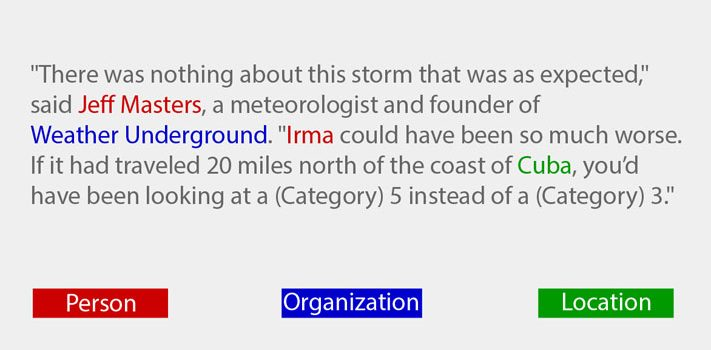

Named Entity Recognition is a process where an algorithm takes a string of text (sentence or paragraph) as input and identifies relevant nouns (people, places, and organizations) that are mentioned in that string



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)

In [ ]:
plt.style.use("ggplot")
import tensorflow as tf
import keras
print("TensorFlow version : " ,tf.__version__)
print("GPU detected " , tf.config.list_physical_devices("GPU"))

TensorFlow version :  2.3.0
GPU detected  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##Loading the Dataset

The dataset which we will be using for NER task is called Annotated Corpus for Named Entity Recognition which is available on kaggle.<br>

<i>source : https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus</i> 

Entities:
<ul>
<li>geo = Geographical Entity
<li>org = Organization
<li>per = Person
<li>gpe = Geopolitical Entity
<li>tim = Time indicator
<li>art = Artifact
<li>eve = Event
<li>nat = Natural Phenomenon

In [ ]:
data = pd.read_csv("/content/drive/My Drive/NER dataset/ner_dataset.csv" , encoding = "Latin1")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [ ]:
data = data.fillna(method = "ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
data["Word"].describe()

count     1048575
unique      35178
top           the
freq        52573
Name: Word, dtype: object

In [ ]:
data['Tag'].describe()

count     1048575
unique         17
top             O
freq       887908
Name: Tag, dtype: object

In [ ]:
words = list(set(data['Word'].values))
words.append("ENDPAD")
tags = list(set(data['Tag'].values))

##Retrieving Sentences and their tags

In [ ]:
class SentenceGetter(object):
  def __init__(self , data):
    self.data = data
    agg_fnc = lambda s : [(w , p,t) for w, p ,t in zip( s["Word"].values.tolist(),
                                                       s["POS"].values.tolist(),
                                                       s["Tag"].values.tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(agg_fnc)
    self.sentence = [s for s in self.grouped]


In [ ]:
getter = SentenceGetter(data)

In [ ]:
sentences = getter.sentence
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

##Mapping between Tags and Sentences

In [ ]:
word2idx = {w : i+1  for i,w in enumerate(words)}
idx2word = { i+1 : w for i,w in enumerate(words)}


In [ ]:
tag2idx = {t : i for i, t in enumerate(tags)}
idx2tag = {i : t for i, t in enumerate(tags)}
tag2idx

{'B-art': 16,
 'B-eve': 8,
 'B-geo': 3,
 'B-gpe': 10,
 'B-nat': 15,
 'B-org': 5,
 'B-per': 13,
 'B-tim': 12,
 'I-art': 1,
 'I-eve': 11,
 'I-geo': 4,
 'I-gpe': 7,
 'I-nat': 2,
 'I-org': 6,
 'I-per': 0,
 'I-tim': 14,
 'O': 9}

##Padding input sequences and splitting into training and test set

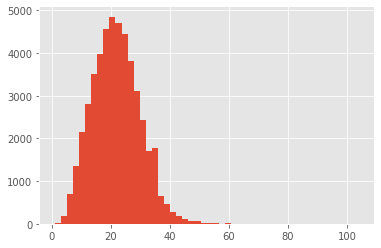

In [ ]:
plt.hist([len(s) for s in sentences] , bins = 50 )
plt.show()

50 appears to be a good cut off value as most of our sentences are of a length less than 50 

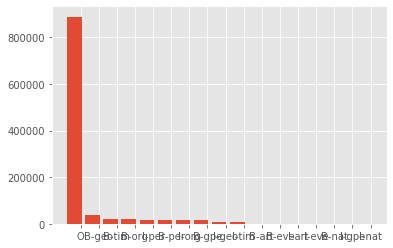

In [ ]:
from collections import Counter

counts = Counter(data['Tag'].values)
tag, value = zip(*counts.items())


indSort = np.argsort(value)[::-1]
# rearrange your data
tag = np.array(tag)[indSort]
value = np.array(value)[indSort]

indexes = np.arange(len(tag))

bar_width = 0.35

plt.bar(indexes, value)

# add labels
plt.xticks(indexes + bar_width, tag)
plt.show()

Tag description is highly skewed

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

max_len = 50  #most of the sentences are of less than 50  words

X = [[word2idx[w[0]] for w in s] for s in sentences] 
X = pad_sequences(X , maxlen = max_len , padding = 'post' , value = len(words))  ## using ENDPAD as filler 
print(X.shape)
X[0]

(47959, 50)


array([ 7748, 14077, 21366, 26414,  7061, 14273, 20631, 13411, 13528,
       12998, 19801,  2875,  7953, 24146,  9505, 12998,  9967, 14077,
       25092, 19494, 33782, 24109,  2013, 25853, 35179, 35179, 35179,
       35179, 35179, 35179, 35179, 35179, 35179, 35179, 35179, 35179,
       35179, 35179, 35179, 35179, 35179, 35179, 35179, 35179, 35179,
       35179, 35179, 35179, 35179, 35179], dtype=int32)

In [ ]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(y , maxlen = max_len , padding = 'post' , value = tag2idx["O"])
y = [to_categorical(i , num_classes = len(tags))  for i in y]

In [ ]:
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(X,y , test_size=0.13, random_state=1)

##Model

In [ ]:
from keras import Model , Input
from keras.layers import Embedding , Dense , LSTM 
from keras.layers import TimeDistributed , Bidirectional , SpatialDropout1D , Dropout
#https://stackoverflow.com/questions/50393666/how-to-understand-spatialdropout1d-and-when-to-use-it

In [ ]:
#https://stackoverflow.com/questions/44924690/keras-the-difference-between-lstm-dropout-and-lstm-recurrent-dropout
input_word = Input(shape = (max_len,))
model = Embedding(input_dim= len(words) +1 , output_dim= 32 ) (input_word)
model = SpatialDropout1D(.15) (model)
model = Bidirectional(LSTM( 64 , return_sequences= True , recurrent_dropout= 0.15)) (model)
out = TimeDistributed(Dense( len(tags) , activation= 'softmax')) (model)

model = Model(input_word , out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 32)            1125760   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 128)           49664     
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            2193      
Total params: 1,177,617
Trainable params: 1,177,617
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer= 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

##Training

In [ ]:
from keras.callbacks import ModelCheckpoint , EarlyStopping

In [ ]:
early_stopping = EarlyStopping(monitor= "val_accuracy",
                               patience = 10 , mode = "max" )

history = model.fit(
    x_train , np.array(y_train),
    validation_split = 0.15 , 
    batch_size = 128 ,
    epochs = 100 ,
    callbacks =[
                early_stopping,
                keras.callbacks.ModelCheckpoint(
                    'model_{val_accuracy:.3f}.h5',
                     save_best_only = True, save_weights_only = False,
                     monitor = 'val_accuracy')
]
)

Epoch 1/100
278/278 [==============================] - 93s 333ms/step - loss: 0.4457 - accuracy: 0.9299 - val_loss: 0.2105 - val_accuracy: 0.9399
Epoch 2/100
278/278 [==============================] - 92s 330ms/step - loss: 0.1692 - accuracy: 0.9485 - val_loss: 0.1414 - val_accuracy: 0.9563
Epoch 3/100
278/278 [==============================] - 93s 334ms/step - loss: 0.1186 - accuracy: 0.9649 - val_loss: 0.0989 - val_accuracy: 0.9733
Epoch 4/100
278/278 [==============================] - 91s 326ms/step - loss: 0.0784 - accuracy: 0.9788 - val_loss: 0.0700 - val_accuracy: 0.9809
Epoch 5/100
278/278 [==============================] - 92s 330ms/step - loss: 0.0567 - accuracy: 0.9842 - val_loss: 0.0607 - val_accuracy: 0.9828
Epoch 6/100
278/278 [==============================] - 92s 332ms/step - loss: 0.0468 - accuracy: 0.9866 - val_loss: 0.0562 - val_accuracy: 0.9838
Epoch 7/100
278/278 [==============================] - 91s 328ms/step - loss: 0.0405 - accuracy: 0.9881 - val_loss: 0.0530 -

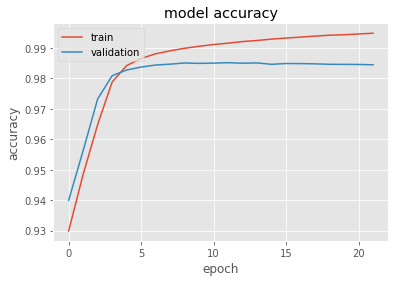

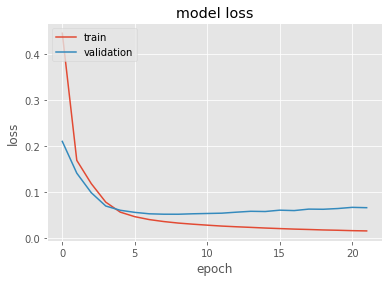

In [ ]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##Testing 

In [ ]:
model.evaluate(x_test , np.array(y_test))

195/195 [==============================] - 6s 29ms/step - loss: 0.0708 - accuracy: 0.9842


We have achieved the test accuracy of about 98.5 % which is commendable .

In [ ]:
y_test = np.array(y_test)
def test_model():
  i = np.random.randint(0 , x_test.shape[0])
  sent = " "
  t = " "
  for idx in range(x_test.shape[1]):
    x = x_test[i , idx]
    y = np.argmax(y_test[i , idx])
    sent+= " " +idx2word[x]
    t += " "+ idx2tag[y]
  print("Actual Sentence : \n" , sent)
  print("Actual Tags : \n" , t)
  pred = model.predict(x_test[i:i+1])
  t = " "
  for p in pred[0]:
    y = np.argmax(p)
    t += " "+ idx2tag[y]
  print("Predicted tags : \n", t )
  


In [ ]:
test_model()

Actual Sentence : 
   A powerful typhoon is approaching a group of islands in the Pacific Ocean south of Tokyo , and officials are warning of heavy rains , strong winds and high waves in the region . ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD
Actual Tags : 
   O O O O O O O O O O O B-geo I-geo I-geo I-geo I-geo O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
Predicted tags : 
   O O O O O O O O O O O B-geo I-geo I-geo I-geo I-geo O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
